# Arguments

In [5]:
# vgg16-ft-pv-self-eb,ap,lm,ct
batch_size = 32
dataset_path_plantvillage = '../datasets/plantvillage'
dataset_path_self = '../datasets/self'
dataset_path_validation = '../datasets/validation'

dataset_paths = [dataset_path_plantvillage, dataset_path_self, dataset_path_validation]

warmup_model_path = 'model-warmup.h5'

checkpoint_path = 'checkpoints-warmup.hdf5'

input_width = 224
input_height = 224
input_depth = 3

# --------------------------------------------------
num_of_epochs = 105
start_epoch = 0
# --------------------------------------------------

# Select training classes

In [2]:
class_paths_training = ['../datasets/self/___Early_blight', '../datasets/self/___Appids', '../datasets/self/___Leaf_miner', '../datasets/self/___Curly_top_virus']

# Load dataset

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image   import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.layers import Input
from keras.models import Model
from keras .applications import VGG16
from keras.optimizers import SGD
from keras.models import Model
from imutils import paths
import numpy as np
import os

import sys
sys.path.append('..')

from utils.preprocessors.resize_image_preprocessor import resizeImagePreprocessor
from utils.preprocessors.img_to_array_preprocessor import ImgToArrayPreprocessor
from utils.io.dataset_loader import DatasetLoader

# construct the image generator for data augmentation
aug = ImageDataGenerator(   rotation_range=30,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

def load_datasets(path_list):
    # Load image paths
    image_paths = []
    print("[INFO] loading images...")
    for path in path_list:
        image_paths.extend(list(paths.list_images(path)))
        
    # Get unique classnames

    class_names = [pt.split(os.path.sep)[-2] for pt in image_paths]
    class_names = [str(x) for x in np.unique(class_names)]

    # Initial image preprocessing
    aap = resizeImagePreprocessor(input_width, input_height)
    iap= ImgToArrayPreprocessor()

    #Load image data and perform image data preprocessing
    dl = DatasetLoader(preprocessors=[aap,iap])
    (data,labels)  = dl.load(image_paths,verbose=500)
    data = data.astype("float") / 255.0


    # train test split
    (train_x,test_x,train_y,test_y) = train_test_split(data,labels,test_size=0.25,random_state=42)

    # convert the labels from integers to vectors
    train_y = LabelBinarizer().fit_transform(train_y)
    test_y = LabelBinarizer().fit_transform(test_y)
    
    return (train_x,test_x,train_y,test_y, class_names)

(train_x,test_x,train_y,test_y, class_names) = load_datasets(class_paths_training)

Using TensorFlow backend.


[INFO] loading images...
[INFO]: Processed 500/4401
[INFO]: Processed 1000/4401
[INFO]: Processed 1500/4401
[INFO]: Processed 2000/4401
[INFO]: Processed 2500/4401
[INFO]: Processed 3000/4401
[INFO]: Processed 3500/4401
[INFO]: Processed 4000/4401


# Load model from disk

In [6]:
# import tensorflow as tf
# print(tf.__version__)


# model = tf.keras.models.load_model(
#     warmup_model_path,
#     custom_objects=None,
#     compile=False
# )

from keras.models import load_model

model = load_model(warmup_model_path)

# Print index of layers

In [7]:
# iterate for all layers in the network and print its' index value
for (i,layer) in enumerate(model.layers):
    print("[INFO] {}\t{}".format(i,layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D
[INFO] 19	Flatten
[INFO] 20	Dense
[INFO] 21	Dropout
[INFO] 22	Dense


# Unfreeze final CONV layers

In [8]:
for layer in model.layers[15:]:
    layer.trainable = True
print('unfrozen')

unfrozen


# Compile model

In [9]:
from keras.optimizers import SGD

# Build the model from the new
print("[INFO] re-compiling model ...")
opt = SGD(lr=0.001, momentum=0.09)
# Fine-tuning with a small learning rate
model.compile(loss = 'categorical_crossentropy',optimizer = opt,
              metrics=['accuracy'])


[INFO] re-compiling model ...


# Checkpoints

In [10]:
from keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', 
save_best_only=True, verbose=1)

callbacks = [checkpoint]



In [11]:
#load checkpoints if existing

import os

if(os.path.exists(checkpoint_path)):
    model.load_weights(checkpoint_path)

# Training Monitor

In [12]:
from utils.callbacks.monitor import Monitor
import pathlib
import json
import os

fig_path = "plot"
json_path = "values.json"
values_path = 'values.json'

callbacks.append(Monitor(fig_path, json_path, start_epoch))

# Fit model

In [13]:

H = model.fit_generator(
    aug.flow(train_x,train_y, batch_size = 32),
             validation_data = (test_x,test_y),
             epochs=num_of_epochs,
             steps_per_epoch = len(train_x) //32,
             verbose = 1,
             callbacks=callbacks)

Epoch 1/105
103/103 [==============================] - 40s 392ms/step - loss: 0.3558 - accuracy: 0.8761 - val_loss: 0.1777 - val_accuracy: 0.9292

Epoch 00001: val_loss improved from inf to 0.17774, saving model to checkpoints-warmup.hdf5
Epoch 2/105
103/103 [==============================] - 37s 357ms/step - loss: 0.2722 - accuracy: 0.9137 - val_loss: 0.1674 - val_accuracy: 0.9419

Epoch 00002: val_loss improved from 0.17774 to 0.16738, saving model to checkpoints-warmup.hdf5
Epoch 3/105
103/103 [==============================] - 36s 350ms/step - loss: 0.1937 - accuracy: 0.9351 - val_loss: 0.1404 - val_accuracy: 0.9419

Epoch 00003: val_loss improved from 0.16738 to 0.14042, saving model to checkpoints-warmup.hdf5
Epoch 4/105
103/103 [==============================] - 35s 343ms/step - loss: 0.1780 - accuracy: 0.9354 - val_loss: 0.1146 - val_accuracy: 0.9582

Epoch 00004: val_loss improved from 0.14042 to 0.11463, saving model to checkpoints-warmup.hdf5
Epoch 5/105
103/103 [===========

# Save model

In [14]:
model.save(model_save_path)

# Evaluate with 20%

In [15]:
from sklearn.metrics import classification_report

print("[INFO] evaluating after initialization...")
predictions = model.predict(test_x,batch_size=batch_size)

print(classification_report(test_y.argmax(axis =1),
                            predictions.argmax(axis =1),
                            target_names=class_names, 
                            digits=4))

[INFO] evaluating after initialization...
                    precision    recall  f1-score   support

         ___Appids     0.9603    0.9959    0.9778       243
___Curly_top_virus     0.9604    0.8899    0.9238       109
   ___Early_blight     0.9845    0.9794    0.9819       388
     ___Leaf_miner     0.9862    0.9889    0.9876       361

          accuracy                         0.9773      1101
         macro avg     0.9728    0.9635    0.9678      1101
      weighted avg     0.9773    0.9773    0.9771      1101



In [16]:
ev = model.evaluate(test_x, test_y)
acc = ev[1] * 100
print('accuracy : ' +  str("%.4f" % round(acc, 4)))

1101/1101 [==============================] - 6s 5ms/step
accuracy : 97.7293


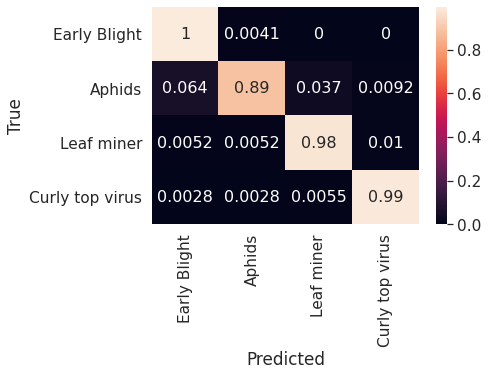

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

class_names = ['Early Blight', 'Aphids', 'Leaf miner', 'Curly top virus']

matrix = confusion_matrix(test_y.argmax(axis=1), predictions.argmax(axis=1))
matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(matrix_normalized, range(len(class_names)), range(len(class_names)))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names) # font size


# Add axis labels
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# x is predicted
# y is true

# Evaluate with validation images

In [18]:
class_paths_validation = ['../datasets/validation/___Early_blight', '../datasets/validation/___Appids', '../datasets/validation/___Leaf_miner', '../datasets/self/___Curly_top_virus']

In [19]:
(train_x,test_x,train_y,test_y, class_names) = load_datasets(class_paths_validation)

from sklearn.metrics import classification_report

print("[INFO] evaluating with validation set...")
predictions = model.predict(test_x,batch_size=batch_size)

print(classification_report(test_y.argmax(axis =1),
                            predictions.argmax(axis =1),
                            target_names=class_names, 
                            digits=4))

[INFO] loading images...
[INFO]: Processed 500/599
[INFO] evaluating with validation set...
                    precision    recall  f1-score   support

         ___Appids     0.6000    0.6000    0.6000         5
___Curly_top_virus     0.9821    0.9821    0.9821       112
   ___Early_blight     0.6471    0.9167    0.7586        12
     ___Leaf_miner     1.0000    0.7619    0.8649        21

          accuracy                         0.9333       150
         macro avg     0.8073    0.8152    0.8014       150
      weighted avg     0.9451    0.9333    0.9351       150



In [20]:
ev = model.evaluate(test_x, test_y)
acc = ev[1] * 100
print('accuracy : ' +  str("%.4f" % round(acc, 4)))

150/150 [==============================] - 1s 5ms/step
accuracy : 93.3333


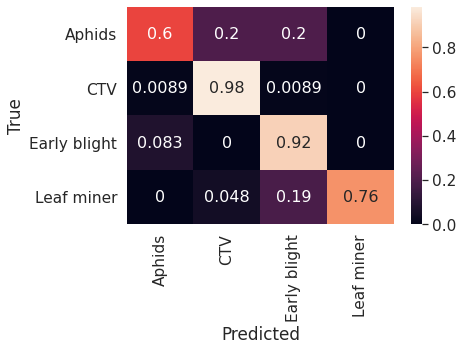

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

class_names = ['Aphids', 'CTV', 'Early blight', 'Leaf miner']

matrix = confusion_matrix(test_y.argmax(axis=1), predictions.argmax(axis=1))
matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(matrix_normalized, range(len(class_names)), range(len(class_names)))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names) # font size


# Add axis labels
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# x is predicted
# y is true